# Sentiment Analysis on the English Translation of the Quran

This notebook performs sentiment analysis on the English translation of the Quran. The workflow includes data loading, preprocessing, exploratory data analysis, word frequency visualization, sentiment and emotion classification, aggregation of results by Surah, and visualization of sentiment distributions.

## 1. Import Required Libraries

Import libraries for data manipulation, visualization, and sentiment analysis.

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

# Natural Language Processing
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package stopwords to C:\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 2. Exploratory Data Analysis

Explore the dataset to understand its structure, check for missing values, and get an overview of the text data.

In [2]:
# Load the dataset (if not already loaded)
df = pd.read_csv('holy_quran-english.csv')

# Display basic info and first few rows
print("Dataset Info:")
df.info()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6236 entries, 0 to 6235
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 6236 non-null   int64 
 1   surahs             6236 non-null   int64 
 2   ayahs              6236 non-null   int64 
 3   ayahs-translation  6236 non-null   object
dtypes: int64(3), object(1)
memory usage: 195.0+ KB


In [3]:
df.describe()

,id,surahs,ayahs
count,6236.000000,6236.000000,6236.000000
mean,3118.500000,33.519724,53.506575
std,1800.322471,26.461261,50.463924
min,1.000000,1.000000,1.000000
25%,1559.750000,11.000000,16.000000
50%,3118.500000,26.000000,38.000000
75%,4677.250000,51.000000,75.000000
max,6236.000000,114.000000,286.000000


In [4]:
print(df.isnull().sum())

id                   0
surahs               0
ayahs                0
ayahs-translation    0
dtype: int64


In [5]:
df.head()

,id,surahs,ayahs,ayahs-translation
0,1,1,1,"In the name of Allah, Most Gracious, Most Merc..."
1,2,1,2,"Praise be to Allah, the Cherisher and Sustaine..."
2,3,1,3,"Most Gracious, Most Merciful;"
3,4,1,4,Master of the Day of Judgment.
4,5,1,5,"Thee do we worship, and Thine aid we seek."


## 3. Preprocess the Text Data

Clean the 'ayahs-translation' column by:
- Removing punctuation
- Converting text to lowercase

In [7]:
import string

# Function to clean text
def clean_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text

df['clean_translation'] = df['ayahs-translation'].apply(clean_text)
df.head()

,id,surahs,ayahs,ayahs-translation,clean_translation
0,1,1,1,"In the name of Allah, Most Gracious, Most Merc...",in the name of allah most gracious most merciful
1,2,1,2,"Praise be to Allah, the Cherisher and Sustaine...",praise be to allah the cherisher and sustainer...
2,3,1,3,"Most Gracious, Most Merciful;",most gracious most merciful
3,4,1,4,Master of the Day of Judgment.,master of the day of judgment
4,5,1,5,"Thee do we worship, and Thine aid we seek.",thee do we worship and thine aid we seek


## 4. Visualize Word Frequencies

Visualize the most common words in the translations using a word cloud and a bar plot.

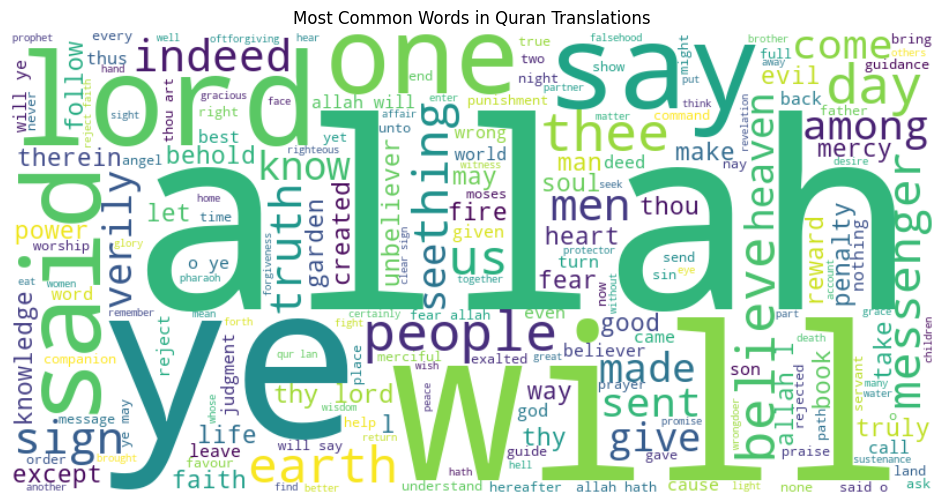

In [8]:
# Combine all cleaned translations
all_text = ' '.join(df['clean_translation'])

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=STOPWORDS).generate(all_text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Quran Translations')
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_14816\1633568994.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette='viridis')


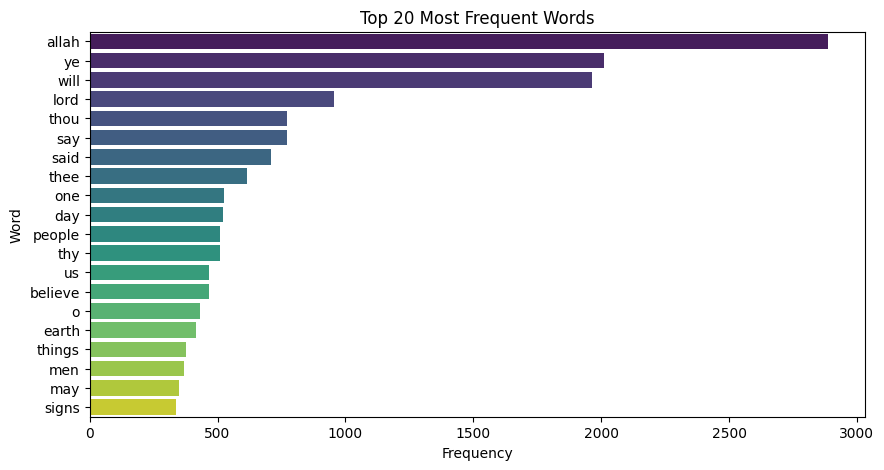

In [9]:
# Bar plot of top 20 words (excluding stopwords)
from collections import Counter

words = all_text.split()
filtered_words = [w for w in words if w not in STOPWORDS]
word_counts = Counter(filtered_words)
common_words = word_counts.most_common(20)

words, counts = zip(*common_words)
plt.figure(figsize=(10,5))
sns.barplot(x=list(counts), y=list(words), palette='viridis')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.title('Top 20 Most Frequent Words')
plt.show()

## 5. Assign Labels to Every Verse

Apply zero-shot classification to each verse to assign thematic, emotional, and sentiment labels. The results are saved for each verse.

In [9]:
from transformers import pipeline
import tqdm

# Load zero-shot classification model
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

# Define label sets
theme_labels = [
    "Tawhid (Oneness of God)",
    "Worship and Obedience",
    "Afterlife and Judgment",
    "Moral and Righteous Living",
    "Creation and Signs",
    "Prophets and Revelation",
    "Good vs Evil (Accountability)",
    "Justice and Social Fairness"
]
emotion_labels = [
    "Affection", "Anger", "Anguish", "Anxiousness", "Awe", "Contempt", "Contentment", 
    "Courage", "Desire", "Despair", "Disappointment", "Distress", "Grace", "Ecstacy", 
    "Empaty", "Envy", "Fear", "Frustration", "Gratitude", "Grief", "Happiness", "Hatred", 
    "Hope", "Hostility", "Humiliation", "Joy", "Love", "Pleasure", "Pride", "Rage", "Regret",
    "Remorse", "Shame", "Suffering", "Trust", "Wonder"
]
sentiment_labels = ["Positive", "Neutral", "Negative"]

# Prepare columns to store results
df['theme'] = ""
df['emotion'] = ""
df['sentiment'] = ""

# Test on first 10 verses only and print the results
for idx, verse in tqdm.tqdm(df['clean_translation'].iloc[:10].items(), total=10):
    # Thematic classification
    theme_result = classifier(verse, candidate_labels=theme_labels, multi_label=True)
    top_themes = [label for label, score in zip(theme_result['labels'], theme_result['scores']) if score > 0.3]

    # Emotion classification
    emotion_result = classifier(verse, candidate_labels=emotion_labels, multi_label=True)
    top_emotions = [label for label, score in zip(emotion_result['labels'], emotion_result['scores']) if score > 0.3]

    # Sentiment classification (single label)
    sentiment_result = classifier(verse, candidate_labels=sentiment_labels)
    top_sentiment = sentiment_result['labels'][0]  # Highest scored sentiment

    # Store results as comma-separated strings
    df.at[idx, 'theme'] = ', '.join(top_themes)
    df.at[idx, 'emotion'] = ', '.join(top_emotions)
    df.at[idx, 'sentiment'] = top_sentiment

    # Print the result for this verse
    print(f"Verse {idx+1}:")
    print(f"Text: {verse}")
    print(f"Theme: {df.at[idx, 'theme']}")
    print(f"Emotion: {df.at[idx, 'emotion']}")
    print(f"Sentiment: {df.at[idx, 'sentiment']}")
    print("-" * 60)

Device set to use cuda:0
 10%|█         | 1/10 [00:01<00:14,  1.56s/it]

Verse 1:
Text: in the name of allah most gracious most merciful
Theme: Worship and Obedience, Tawhid (Oneness of God), Moral and Righteous Living
Emotion: Grace, Contentment, Affection, Gratitude
Sentiment: Positive
------------------------------------------------------------


 20%|██        | 2/10 [00:03<00:12,  1.51s/it]

Verse 2:
Text: praise be to allah the cherisher and sustainer of the worlds
Theme: Tawhid (Oneness of God), Worship and Obedience, Moral and Righteous Living, Creation and Signs, Justice and Social Fairness, Prophets and Revelation
Emotion: Gratitude, Awe, Grace, Affection, Trust, Contentment, Love
Sentiment: Positive
------------------------------------------------------------


 30%|███       | 3/10 [00:04<00:10,  1.46s/it]

Verse 3:
Text: most gracious most merciful
Theme: Moral and Righteous Living, Tawhid (Oneness of God), Worship and Obedience, Justice and Social Fairness
Emotion: Grace, Empaty, Contentment, Awe, Affection, Gratitude, Love, Ecstacy, Wonder, Trust, Joy, Pleasure, Hope, Courage, Desire, Happiness
Sentiment: Positive
------------------------------------------------------------


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
 40%|████      | 4/10 [00:05<00:08,  1.43s/it]

Verse 4:
Text: master of the day of judgment
Theme: Afterlife and Judgment, Good vs Evil (Accountability), Tawhid (Oneness of God)
Emotion: Contempt
Sentiment: Negative
------------------------------------------------------------


 50%|█████     | 5/10 [00:07<00:07,  1.40s/it]

Verse 5:
Text: thee do we worship and thine aid we seek
Theme: Worship and Obedience, Tawhid (Oneness of God), Moral and Righteous Living, Justice and Social Fairness
Emotion: Grace, Awe, Trust, Affection, Love, Gratitude, Empaty, Ecstacy, Distress, Desire, Hope, Courage
Sentiment: Positive
------------------------------------------------------------


 60%|██████    | 6/10 [00:08<00:05,  1.39s/it]

Verse 6:
Text: show us the straight way
Theme: Moral and Righteous Living, Good vs Evil (Accountability), Justice and Social Fairness
Emotion: 
Sentiment: Neutral
------------------------------------------------------------


 70%|███████   | 7/10 [00:10<00:04,  1.47s/it]

Verse 7:
Text: the way of those on whom thou hast bestowed thy grace those whose portion is not wrath and who go not astray
Theme: Moral and Righteous Living, Worship and Obedience, Justice and Social Fairness, Tawhid (Oneness of God), Prophets and Revelation
Emotion: Grace, Gratitude, Trust, Hope, Courage, Empaty, Affection, Contentment, Love, Joy, Ecstacy, Awe
Sentiment: Positive
------------------------------------------------------------


 80%|████████  | 8/10 [00:11<00:02,  1.48s/it]

Verse 8:
Text: alm
Theme: Tawhid (Oneness of God), Moral and Righteous Living, Worship and Obedience, Good vs Evil (Accountability), Justice and Social Fairness
Emotion: Anxiousness, Awe, Anger, Empaty, Anguish, Suffering, Hostility
Sentiment: Negative
------------------------------------------------------------


 90%|█████████ | 9/10 [00:13<00:01,  1.47s/it]

Verse 9:
Text: this is the book in it is guidance sure without doubt to those who fear allah
Theme: Moral and Righteous Living, Tawhid (Oneness of God), Prophets and Revelation, Afterlife and Judgment, Worship and Obedience, Justice and Social Fairness
Emotion: Fear, Trust, Courage
Sentiment: Positive
------------------------------------------------------------


100%|██████████| 10/10 [00:14<00:00,  1.46s/it]

Verse 10:
Text: who believe in the unseen are steadfast in prayer and spend out of what we have provided for them
Theme: Worship and Obedience, Tawhid (Oneness of God), Afterlife and Judgment, Moral and Righteous Living
Emotion: Trust, Courage, Hope, Ecstacy, Empaty, Grace
Sentiment: Negative
------------------------------------------------------------


In [10]:
from transformers import pipeline
import tqdm

# Load zero-shot classification model
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

# Define label sets
theme_labels = [
    "Tawhid (Oneness of God)",
    "Worship and Obedience",
    "Afterlife and Judgment",
    "Moral and Righteous Living",
    "Creation and Signs",
    "Prophets and Revelation",
    "Good vs Evil (Accountability)",
    "Justice and Social Fairness"
]
emotion_labels = ["Affection", "Anger", "Anguish", "Anxiousness", "Awe", "Contempt", "Contentment", 
                  "Courage", "Desire", "Despair", "Disappointment", "Distress", "Grace", "Ecstacy", 
                  "Empaty", "Envy", "Fear", "Frustration", "Gratitude", "Grief", "Happiness", "Hatred", 
                  "Hope", "Hostility", "Humiliation", "Joy", "Love","Pleasure", "Pride", "Rage", "Regret",
                  "Remorse", "Shame", "Suffering", "Trust", "Wonder"]
sentiment_labels = ["Positive", "Neutral", "Negative"]

# Prepare columns to store results
df['theme'] = ""
df['emotion'] = ""
df['sentiment'] = ""

# Apply classification to each verse
for idx, verse in tqdm.tqdm(df['clean_translation'].items(), total=len(df)):
    # Thematic classification
    theme_result = classifier(verse, candidate_labels=theme_labels, multi_label=True)
    top_themes = [label for label, score in zip(theme_result['labels'], theme_result['scores']) if score > 0.3]

    # Emotion classification
    emotion_result = classifier(verse, candidate_labels=emotion_labels, multi_label=True)
    top_emotions = [label for label, score in zip(emotion_result['labels'], emotion_result['scores']) if score > 0.3]

    # Sentiment classification
    sentiment_result = classifier(verse, candidate_labels=sentiment_labels)
    top_sentiment = sentiment_result['labels'][0]  # Highest scored sentiment

    # Store results as comma-separated strings
    df.at[idx, 'theme'] = ', '.join(top_themes)
    df.at[idx, 'emotion'] = ', '.join(top_emotions)
    df.at[idx, 'sentiment'] = top_sentiment

# Save updated DataFrame to CSV
df.to_csv('quran_sentiment_theme_emotion.csv', index=False)
print("Results saved to quran_sentiment_theme_emotion.csv")

Device set to use cuda:0
100%|██████████| 6236/6236 [3:08:55<00:00,  1.82s/it]  

Results saved to quran_sentiment_theme_emotion.csv


## 6. Aggregate Sentiment Scores by Surah

Group the sentiment scores by 'surahs' and calculate the average sentiment, most common emotion, and most common theme for each surah.

In [26]:
df = pd.read_csv("quran_sentiment_theme_emotion.csv")

# Map sentiment to numeric scores
sentiment_map = {'Positive': 1, 'Neutral': 0, 'Negative': -1}
df['sentiment_score'] = df['sentiment'].map(sentiment_map)

from collections import Counter

# Helper functions to get the most common emotion/theme by count
def most_common_count(cell):
    items = []
    for entry in cell.dropna():
        items.extend([e.strip() for e in entry.split(',') if e.strip()])
    if items:
        return Counter(items).most_common(1)[0][0]
    return ''

agg_funcs = {
    'sentiment_score': 'mean',
    'emotion': most_common_count,
    'theme': most_common_count
}
surah_agg = df.groupby('surahs').agg(agg_funcs).reset_index()
surah_agg.rename(columns={
    'sentiment_score': 'avg_sentiment',
    'emotion': 'most_common_emotion',
    'theme': 'most_common_theme'
}, inplace=True)

display(surah_agg.head())

,surahs,avg_sentiment,most_common_emotion,most_common_theme
0,1,0.571429,Grace,Tawhid (Oneness of God)
1,2,-0.090909,Trust,Moral and Righteous Living
2,3,-0.015000,Trust,Moral and Righteous Living
3,4,-0.232955,Awe,Moral and Righteous Living
4,5,-0.241667,Trust,Moral and Righteous Living


## 7. Visualize Sentiment Distribution

Visualize the distribution of sentiment scores across all ayahs and by surah, as well as the most common emotion and theme per surah.

### i. Grouped by Surah

C:\Users\User\AppData\Local\Temp\ipykernel_14816\3969767756.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='surahs', y='avg_sentiment', data=surah_agg, palette='coolwarm')


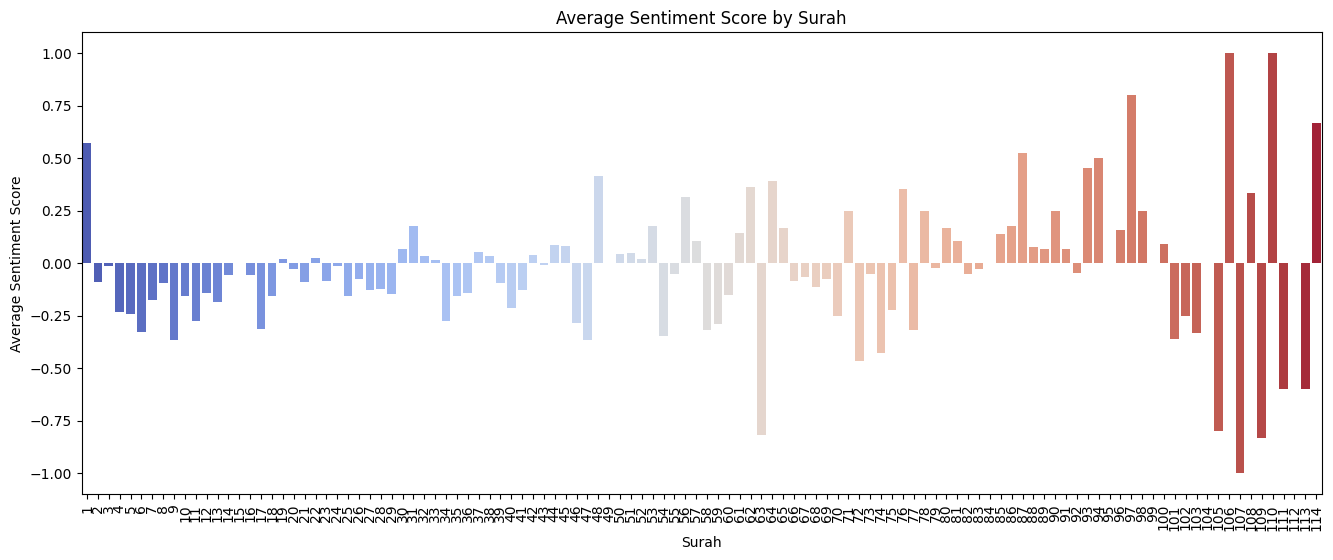

In [28]:
# Barplot: Average sentiment by surah
plt.figure(figsize=(16,6))
sns.barplot(x='surahs', y='avg_sentiment', data=surah_agg, palette='coolwarm')
plt.title('Average Sentiment Score by Surah')
plt.xlabel('Surah')
plt.ylabel('Average Sentiment Score')
plt.xticks(rotation=90)
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_14816\1589757044.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='most_common_emotion', data=surah_agg, palette='Set2', order=surah_agg['most_common_emotion'].value_counts().index)


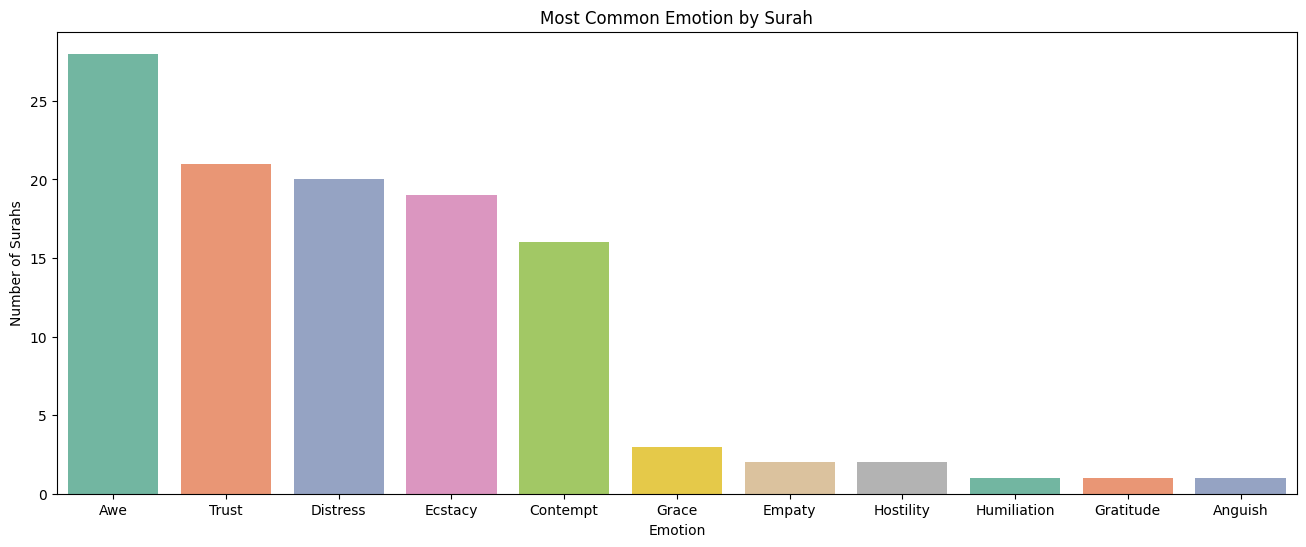

In [33]:
# Barplot: Most common emotion by surah
plt.figure(figsize=(16,6))
sns.countplot(x='most_common_emotion', data=surah_agg, palette='Set2', order=surah_agg['most_common_emotion'].value_counts().index)
plt.title('Most Common Emotion by Surah')
plt.xlabel('Emotion')
plt.ylabel('Number of Surahs')
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_14816\3193051830.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='most_common_theme', data=surah_agg, palette='Set3', order=surah_agg['most_common_theme'].value_counts().index)


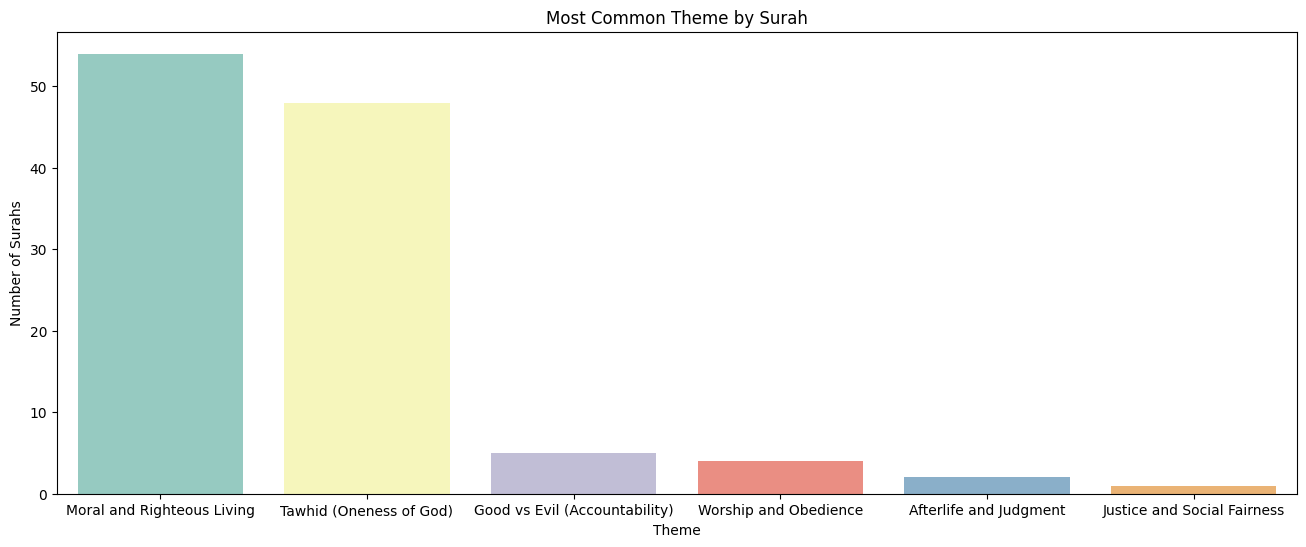

In [34]:
# Barplot: Most common theme by surah
plt.figure(figsize=(16,6))
sns.countplot(x='most_common_theme', data=surah_agg, palette='Set3', order=surah_agg['most_common_theme'].value_counts().index)
plt.title('Most Common Theme by Surah')
plt.xlabel('Theme')
plt.ylabel('Number of Surahs')
plt.show()

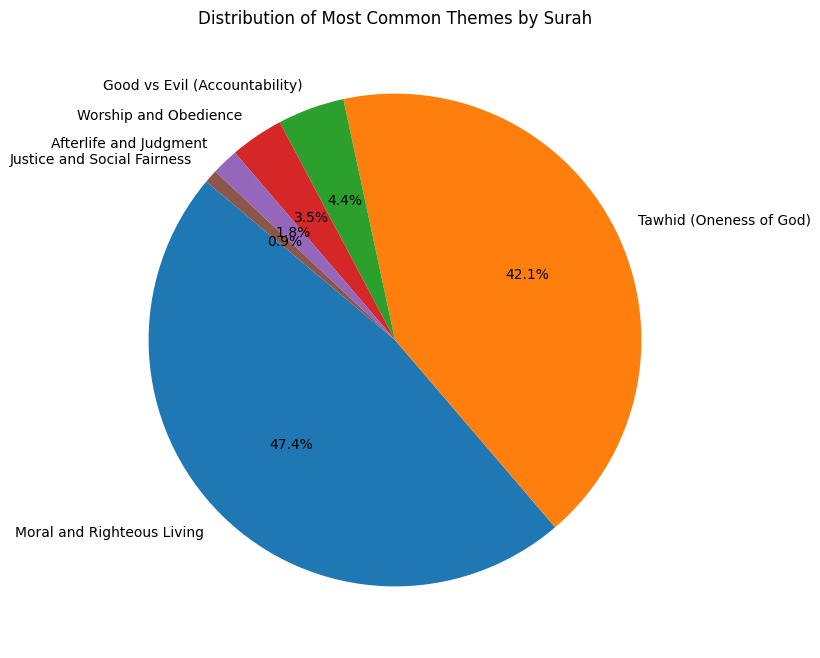

In [31]:
theme_counts = surah_agg['most_common_theme'].value_counts()

# Pie chart
theme_counts.plot(kind='pie', autopct='%1.1f%%', figsize=(8, 8), startangle=140)
plt.title('Distribution of Most Common Themes by Surah')
plt.ylabel('')
plt.show()

### ii. Verse-level

C:\Users\User\AppData\Local\Temp\ipykernel_14816\84567888.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Emotion', data=emotion_df, palette='Reds_r')


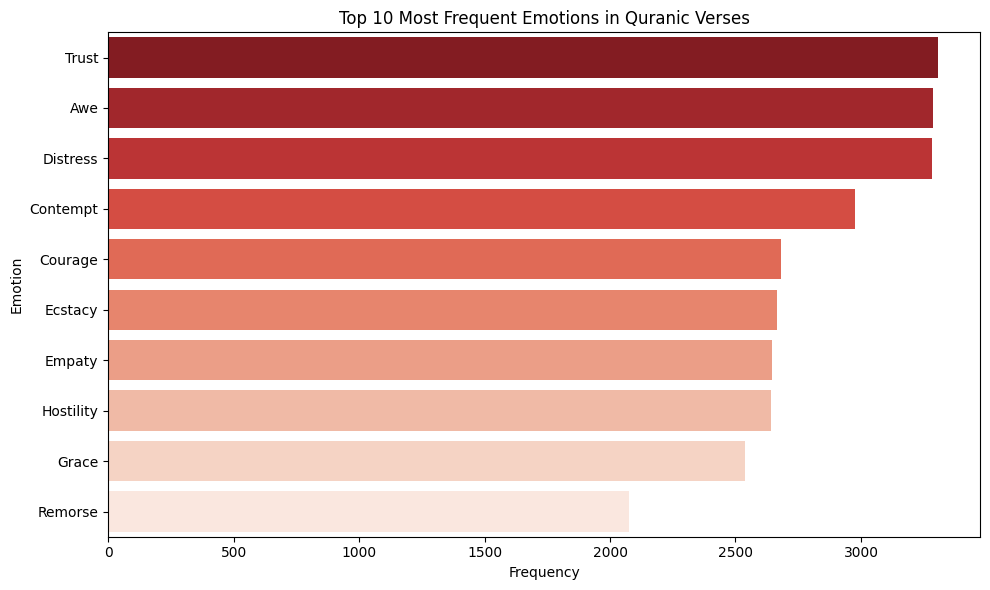

In [ ]:
# Bar chart for overall top emotion frequencies
emotion_freq = Counter([e for sublist in df['emotion_list'] for e in sublist])
emotion_df = pd.DataFrame(emotion_freq.items(), columns=['Emotion', 'Count']).sort_values(by='Count', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='Count', y='Emotion', data=emotion_df, palette='Reds_r')
plt.title('Top 10 Most Frequent Emotions in Quranic Verses')
plt.xlabel('Frequency')
plt.ylabel('Emotion')
plt.tight_layout()
plt.show()

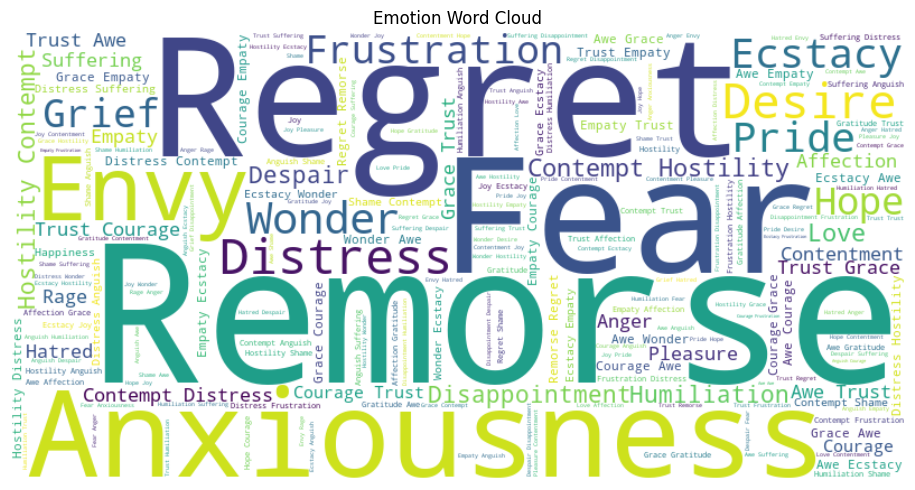

In [50]:
# Word Cloud for emotions
emotion_words = ' '.join([e for sublist in df['emotion_list'] for e in sublist])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(emotion_words)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Emotion Word Cloud')
plt.tight_layout()
plt.show()

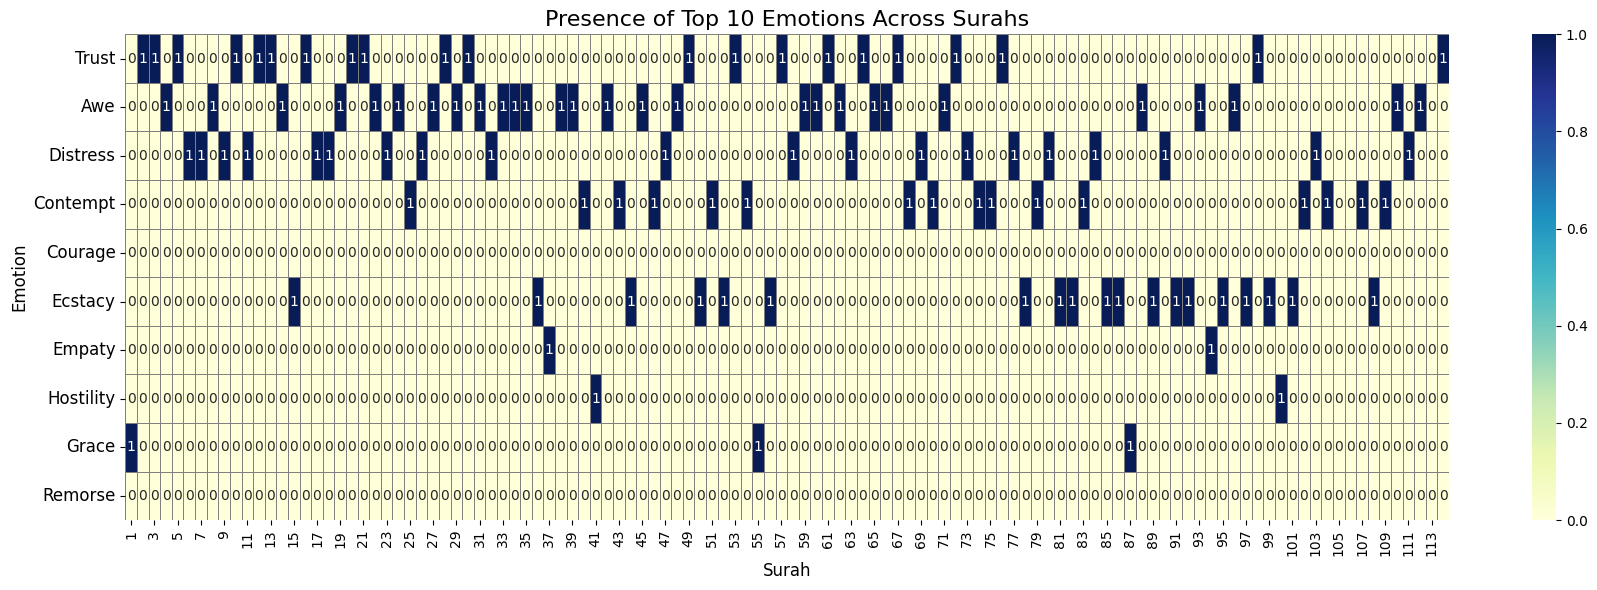

In [52]:
# Prepare a matrix: rows=surahs, columns=top_emotions
surah_emotion_matrix = pd.DataFrame(0, index=surah_agg['surahs'], columns=top_emotions)

for idx, row in surah_agg.iterrows():
    for emotion in row['most_common_emotion'].split(','):
        emotion = emotion.strip()
        if emotion in top_emotions:
            surah_emotion_matrix.at[row['surahs'], emotion] = 1

# Plot heatmap for top emotions across surahs
plt.figure(figsize=(18, 6))
sns.heatmap(
    surah_emotion_matrix.T,
    cmap='YlGnBu',
    cbar=True,
    linewidths=0.5,
    linecolor='gray',
    square=False,
    annot=True,
    fmt='d'
)
plt.title('Presence of Top 10 Emotions Across Surahs', fontsize=16)
plt.xlabel('Surah', fontsize=12)
plt.ylabel('Emotion', fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.xticks(fontsize=10, rotation=90)
plt.tight_layout()
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_14816\428798812.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Theme', data=theme_df, palette='Blues_r')


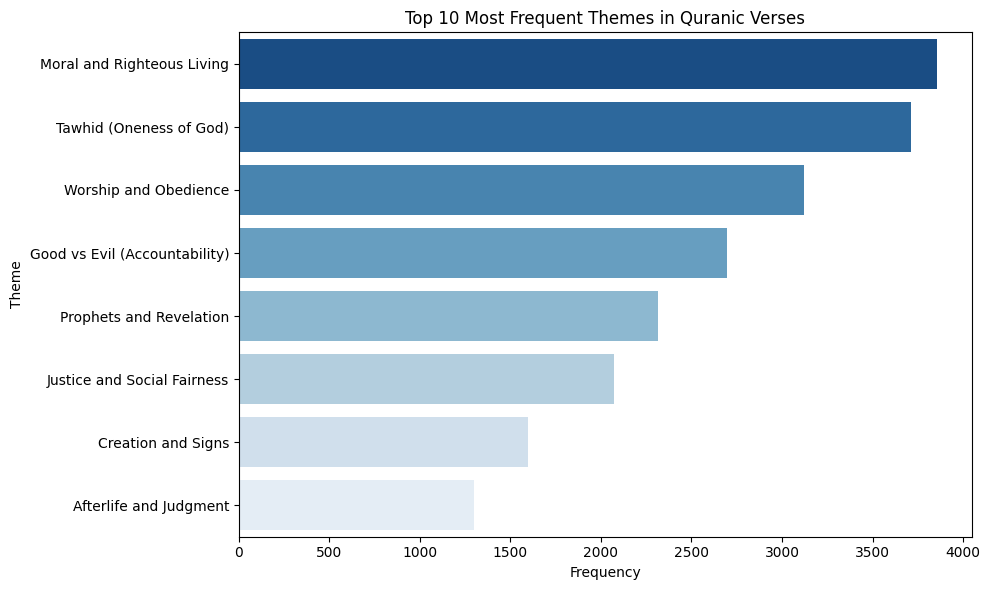

In [44]:
# Bar chart for overall top theme frequencies
theme_freq = Counter([t for sublist in df['theme_list'] for t in sublist])
theme_df = pd.DataFrame(theme_freq.items(), columns=['Theme', 'Count']).sort_values(by='Count', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='Count', y='Theme', data=theme_df, palette='Blues_r')
plt.title('Top 10 Most Frequent Themes in Quranic Verses')
plt.xlabel('Frequency')
plt.ylabel('Theme')
plt.tight_layout()
plt.show()

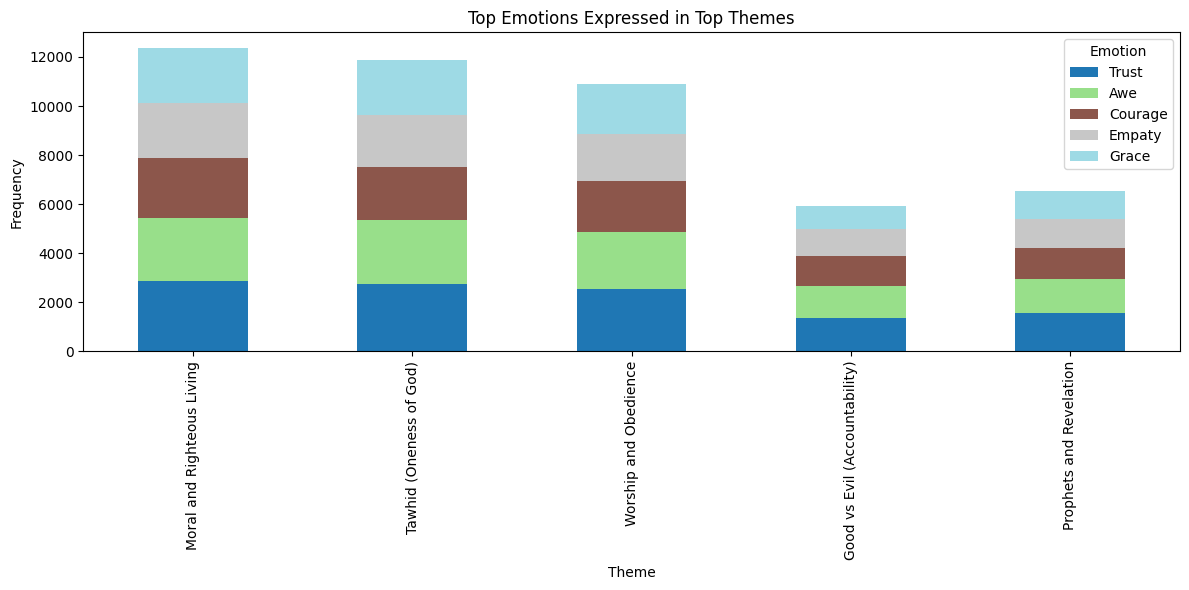

In [47]:
# Create cross-tab of emotion vs theme (optional aggregation)
theme_emotion_pairs = []
for _, row in df.iterrows():
    for theme in row['theme_list']:
        for emotion in row['emotion_list']:
            theme_emotion_pairs.append((theme, emotion))

pair_df = pd.DataFrame(theme_emotion_pairs, columns=['Theme', 'Emotion'])
pair_counts = pd.crosstab(pair_df['Theme'], pair_df['Emotion'])

# Only keep top N themes and emotions
pair_counts = pair_counts.loc[pair_counts.sum(axis=1).nlargest(5).index, pair_counts.sum().nlargest(5).index]

# Plot
pair_counts.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='tab20')
plt.title('Top Emotions Expressed in Top Themes')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

---

**Conclusion:**  
This notebook provides an end-to-end sentiment analysis workflow on the English translation of the Quran, including data loading, preprocessing, exploratory analysis, visualization, sentiment and emotion classification, aggregation, and result visualization.